<a href="https://colab.research.google.com/github/dctian/DeepPiCar/blob/master/models/lane_navigation/code/end_to_end_lane_navigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End-to-End Lane Navigation via Nvidia Model
Author: David Tian Co-Author: Julian Cecchini

Note: Base code was taken from article and modified for project.

Date: 2022-08-09

For the full breakdown of the original code and explanation, please visit the David Tian's posts at [DeepPiCar - Part 5: Autonomous Lane Navigation via Deep Learning](https://medium.com/@dctian/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110?source=your_stories_page---------------------------)

In [30]:
# Mount my Google Drive.  It will ask for an authenticate code
from google.colab import drive
print(drive)
drive.mount('/content/drive', force_remount=True)
model_output_dir = '/content/drive/My Drive/Colab_Notebooks/LaneNavigation'

<module 'google.colab.drive' from '/usr/local/lib/python3.7/dist-packages/google/colab/drive.py'>
Mounted at /content/drive


In [2]:
#################### SEND ALERT EMAIL AT FINISH WITH GMAIL #####################
# To send email from Python from your google account, MUST 
# 1) Enable less secure app
# https://myaccount.google.com/lesssecureapps
# 2) Disable Unlock Capcha
# https://accounts.google.com/b/0/DisplayUnlockCaptcha

import smtplib

def SendEmail(msg):
    # store gmail password in my google drive (not the most secure way)
    # but it is much safer than storing it directly in this notebook, 
    # and upload it to github for everyone to see
        
    gmail_user = 'education4t10n@gmail.com'  
    gmail_password = "ygtl qhfi rchm zhim"

    sent_from = gmail_user  
    to = ['education4t10n@gmail.com']  
    subject = msg  
    body = '%s\n\n- David' % msg

    email_text = \
"""From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.ehlo()
    server.starttls()
    server.login(gmail_user, gmail_password)
    server.sendmail(sent_from, to, email_text)
    server.quit()

    print(f'Email: \n{email_text}')



In [3]:
!pip uninstall -y numpy
!pip uninstall -y tensorflow
!pip uninstall keras

Found existing installation: numpy 1.21.6
Uninstalling numpy-1.21.6:
  Successfully uninstalled numpy-1.21.6
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/keras-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/keras/*
Proceed (y/n)? y
  Successfully uninstalled keras-2.8.0


In [4]:
!pip install numpy==1.21.6
!pip install tensorflow==2.4.0
!pip install keras==2.4.3


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.7 MB 15.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-vis 0.4.1 requires keras, which is not installed.
kapre 0.3.7 requires tensorflow>=2.0.0, which is not installed.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 132 kB 64.9 MB/s 
     |████████████████████████████████| 2.9 MB 54.4 MB/s 
     |████████████████████████████████| 14.8 MB 58.7 MB/s 
     |████████████████████████████████| 462 kB 68.2 MB/s 
     |████████████████████████████████| 3.8 MB 54.8 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68709 sha256=f1efe1169e41984f1abfed08e65b4d0d22d62e33fa359b8d3d128a713c47e179
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: numpy
    Found existing installation: n

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports Packages

In [1]:
# imports

# python standard libraries
import os
import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
import keras
from keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image


tf.__version__: 2.4.0
keras.__version__: 2.4.3


## Load Train Data

drive  sample_data
1199
image_path: /content/drive/MyDrive/Colab_Notebooks/image2/video4_033_092.png
steering_Angle: 92


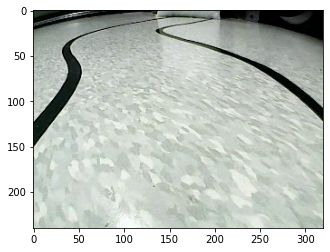

In [2]:
# import images
#!cd /content
#!git clone https://github.com/dctian/DeepPiCar

!ls
data_dir = '/content/drive/MyDrive/Colab_Notebooks/image2'
file_list = os.listdir(data_dir)
print(len(file_list))
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4])  # 092 part of video01_143_092.png is the angle. 90 is go straight
        steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles


(array([15.0000, 7.0000, 9.0000, 8.0000, 7.0000, 11.0000, 12.0000, 14.0000,
        12.0000, 17.0000, 46.0000, 334.0000, 479.0000, 57.0000, 15.0000,
        15.0000, 10.0000, 14.0000, 14.0000, 15.0000, 14.0000, 16.0000,
        19.0000, 14.0000, 16.0000]),
 array([32.0000, 36.7600, 41.5200, 46.2800, 51.0400, 55.8000, 60.5600,
        65.3200, 70.0800, 74.8400, 79.6000, 84.3600, 89.1200, 93.8800,
        98.6400, 103.4000, 108.1600, 112.9200, 117.6800, 122.4400,
        127.2000, 131.9600, 136.7200, 141.4800, 146.2400, 151.0000]),
 <a list of 25 Patch objects>)

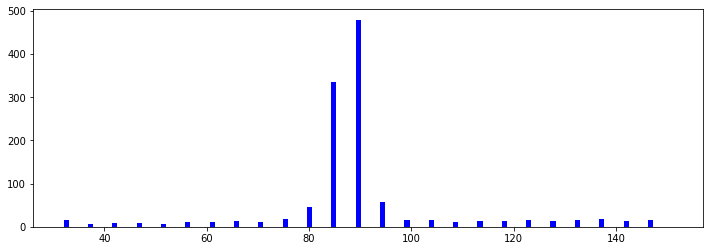

In [3]:
# Look at the distribution of steering angle
num_of_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

Notice that the above diagram contains angeles mostly smaller than 90.  This makes sense, because in our training data, The car was mostly turning left.  This is going to fine, because we will balance the data by randomly flip the image, and the steering angle in the image generator process.

Training data: 952
Validation data: 238


Text(0.5, 1.0, 'Validation Data')

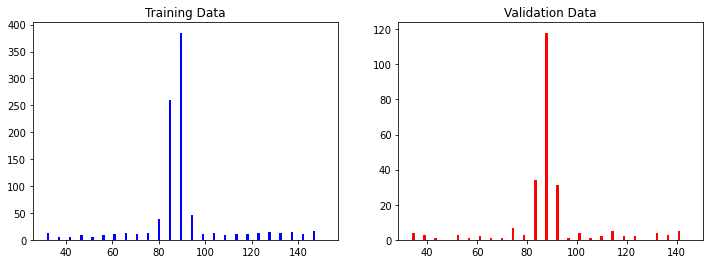

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split( image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

# plot the distributions of train and valid, make sure they are consistent
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')


##Image Augumentation
Since we only have a few hundred images, to train a deep network, we need a lot more images.   Instead of running our car, let's try to augment our data. There are a couple of ways to do that.

1. Zoom: crop out a smaller image from the center
1. Pan: crop out a smaller image from left or right side
1. adjust brightness of the image
1. flip the image horizontally, i.e do a left to right flip, and change the steering angle coorespondingly
1. introduce an Gaussian blur

We can combine the above augmentation techniques to generate 100s times of the training images, with just a few hundred real images.



Text(0.5, 1.0, 'zoomed')

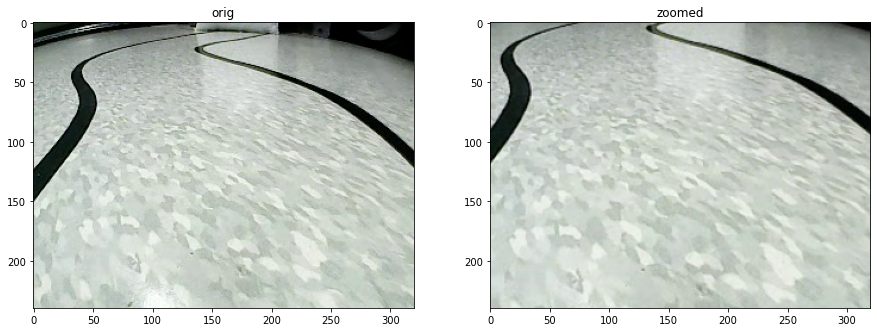

In [5]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_zoom = zoom(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_zoom)
axes[1].set_title("zoomed")


Text(0.5, 1.0, 'panned')

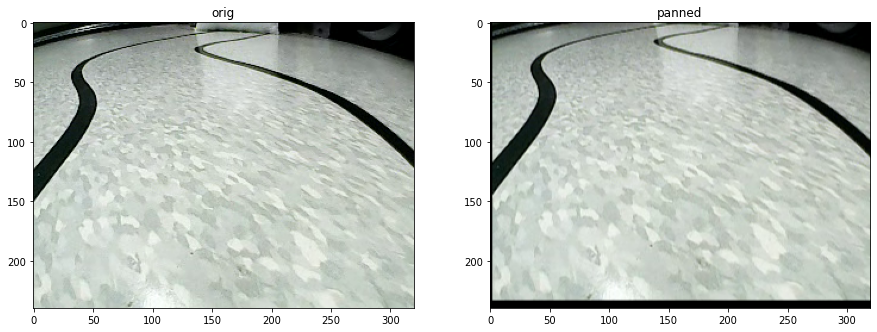

In [6]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_pan = pan(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_pan)
axes[1].set_title("panned")


Text(0.5, 1.0, 'brightness adjusted')

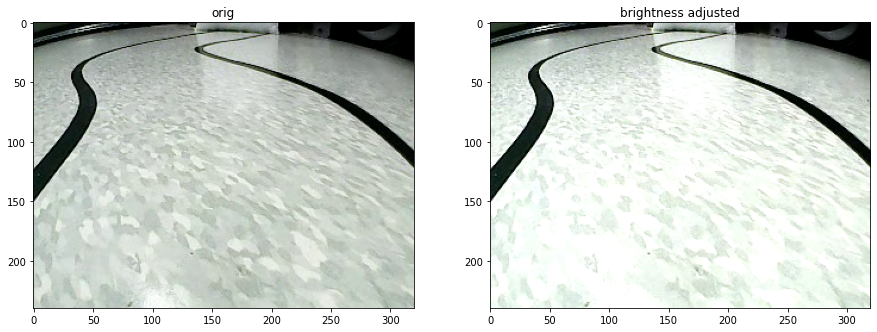

In [7]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_brightness = adjust_brightness(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_brightness)
axes[1].set_title("brightness adjusted")

Text(0.5, 1.0, 'blurred')

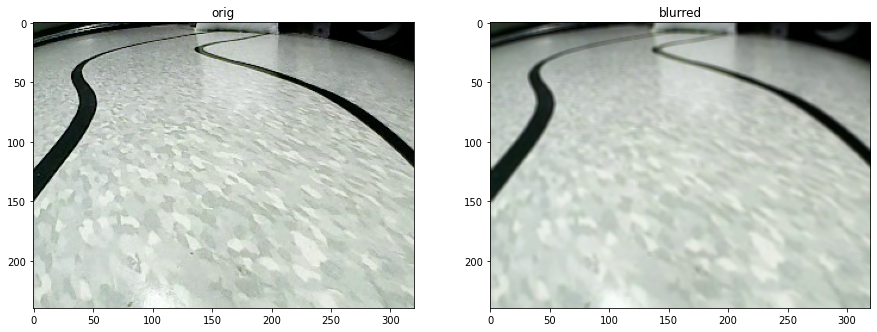

In [8]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_blur = blur(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_blur)
axes[1].set_title("blurred")

Text(0.5, 1.0, 'flipped, angle=92')

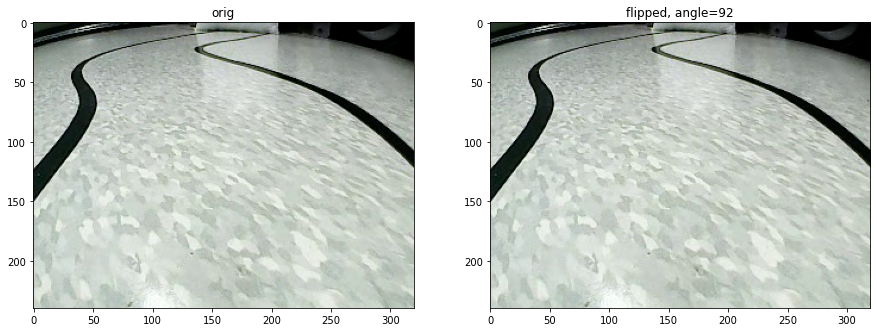

In [22]:
def random_flip(image, steering_angle):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        # randomly flip horizon
        image = cv2.flip(image,1)
        steering_angle = 180 - steering_angle
        
   
    return image, steering_angle

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_flip, steering_angle = random_flip(image_orig, steering_angles[image_index])
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_flip)
axes[1].set_title("flipped, angle=%s" % steering_angle)

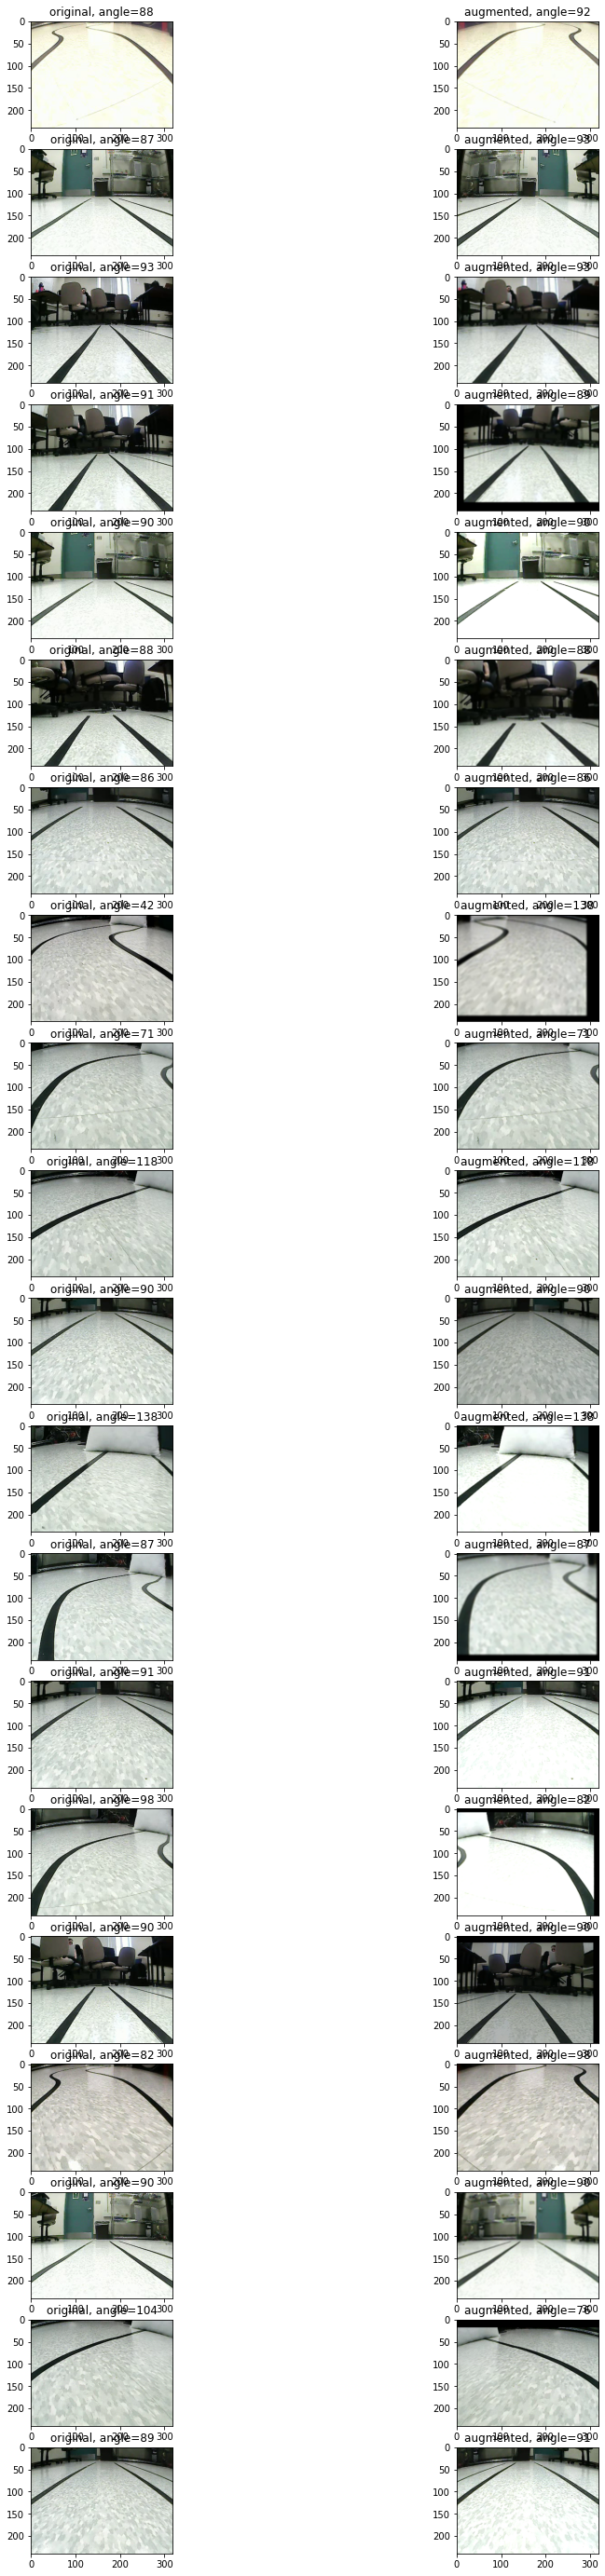

In [23]:
# put it together
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle

# show a few randomly augmented images
ncol = 2
nrow = 20
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

for i in range(nrow):
    rand_index = random.randint(0, len(image_paths) - 1)
    image_path = image_paths[rand_index]
    steering_angle_orig = steering_angles[rand_index]
    
    image_orig = my_imread(image_path)
    image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
    axes[i][0].imshow(image_orig)
    axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
    axes[i][1].imshow(image_aug)
    axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

## Preprocess Training Data for Nvidia Model

Text(0.5, 1.0, 'processed')

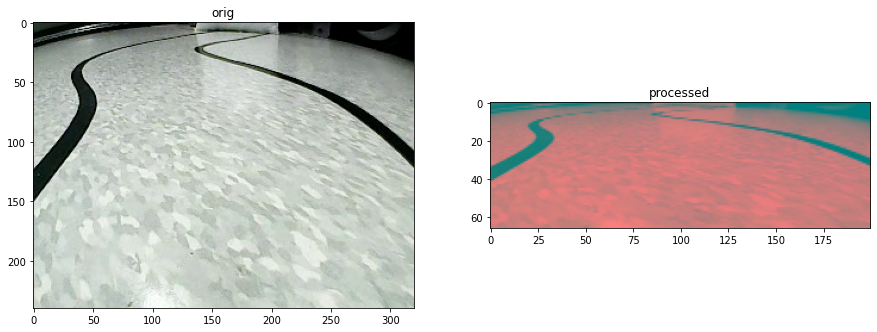

In [24]:
def img_preprocess(image):
    height, _, _ = image.shape
    #image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relavant for lane following
    image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing, the processed image becomes black for some reason.  do we need this?
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")


## Create and Train Model

This is the Nvidia CNN Model Architecture. The input layer is at the bottom with size of 200x66 in YUV color space ![](https://github.com/dctian/DeepPiCar/raw/master/models/lane_navigation/doc/NVidia%20Model%20Architecture.JPG) .



In [25]:
def nvidia_model():
    model = Sequential(name='Nvidia_Model')
    
    # elu=Expenential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu')) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    #model.add(keras.layers.BatchNormalization())
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1)) 
    
    # since this is a regression problem not classification problem,
    # we use MSE (Mean Squared Error) as loss function
    optimizer = Adam(learning_rate=(1e-3)*0.75) # lr is learning rate
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [26]:
model = nvidia_model()
print(model.summary())
# check at we will have 252,219 trainable parameters

Model: "Nvidia_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
dropout (Dropout)            (None, 3, 20, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)             

In [27]:

def image_data_generator(image_paths, steering_angles, batch_size, is_training):
    while True:
        random_indices=list(range(len(image_paths)))
        batch_images = []
        batch_steering_angles = []
        for i in range(batch_size):
            random_index =random_indices.pop(random.randint(0, len(random_indices)-1))#len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            if is_training:
                # training: augment image
                image, steering_angle = random_augment(image, steering_angle)
              
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))
            
            

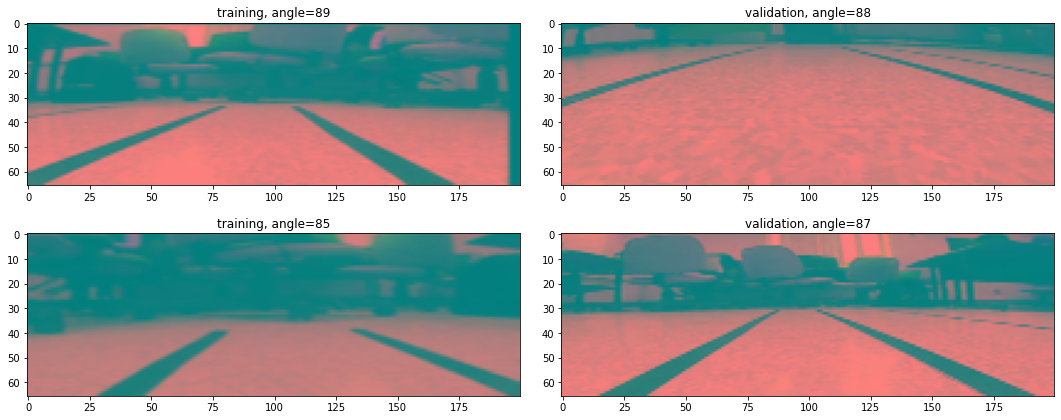

In [28]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])


In [ ]:
# start Tensorboard before model fit, so we can see the epoch tick in Tensorboard
# Jupyter Notebook embedded Tensorboard is a new feature in TF 2.0!!  

# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs/'
#!rm -rf $log_dir_root


In [ ]:
# this block prevents the training from starting if we Run All
DO_NOT_RUN_ALL

In [31]:
# saves the model weights after each epoch if the validation loss decreased
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'lane_navigation_check.h5'), verbose=1, save_best_only=True)

#SendEmail("lane nav train started")
history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=200, is_training=True),
                              steps_per_epoch=300,
                              epochs=15,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=200, is_training=False),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'lane_navigation_final.h5'))

date_str = datetime.datetime.now().strftime("%y%m%d_%H%M%S")
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
SendEmail("lane nav train finished. val_loss from %.1f to %.1f" % (history.history['val_loss'][0], history.history['val_loss'][-1]))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
300/300 [==============================] - 1375s 5s/step - loss: 1014.2132 - val_loss: 289.9237

Epoch 00001: val_loss improved from inf to 289.92371, saving model to /content/drive/My Drive/Colab_Notebooks/LaneNavigation/lane_navigation_check.h5
Epoch 2/15
300/300 [==============================] - 576s 2s/step - loss: 343.5507 - val_loss: 122.2665

Epoch 00002: val_loss improved from 289.92371 to 122.26651, saving model to /content/drive/My Drive/Colab_Notebooks/LaneNavigation/lane_navigation_check.h5
Epoch 3/15
300/300 [==============================] - 574s 2s/step - loss: 195.4952 - val_loss: 56.3804

Epoch 00003: val_loss improved from 122.26651 to 56.38041, saving model to /content/drive/My Drive/Colab_Notebooks/LaneNavigation/lane_navigation_check.h5
Epoch 4/15
300/300 [==============================] - 573s 2s/step - loss: 104.2951 - val_loss: 17.1074

Epoch 00004: val_loss improved from 56.38041 to 17.10744, saving model to /content/drive/My Drive/Colab_Notebooks/L

NameError: ignored

## Check Trained Model on Validation Data

In [32]:
history.history


{'loss': [494.6184387207031,
  314.6026611328125,
  171.5857391357422,
  89.59365844726562,
  54.46155548095703,
  39.02708435058594,
  30.798154830932617,
  25.748729705810547,
  22.336889266967773,
  20.195478439331055,
  18.67755699157715,
  16.727935791015625,
  15.800591468811035,
  15.088383674621582,
  14.090954780578613],
 'val_loss': [289.9237060546875,
  122.26651000976562,
  56.38041305541992,
  17.107444763183594,
  12.613080024719238,
  10.52168083190918,
  11.513405799865723,
  9.059372901916504,
  7.582042217254639,
  7.616187572479248,
  5.7068352699279785,
  6.8963189125061035,
  6.876600742340088,
  5.50780725479126,
  5.1699018478393555]}

In [33]:
# plot training and validation losses
# this should be the same as tensorboard
history_path = os.path.join(model_output_dir,'history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

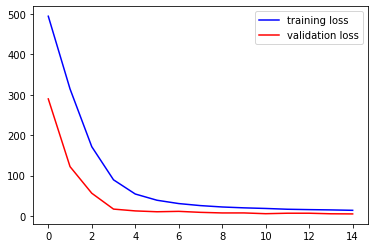

In [34]:
history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/lane_navigation_check.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

mse       = 5.9
r_squared = 97.94%



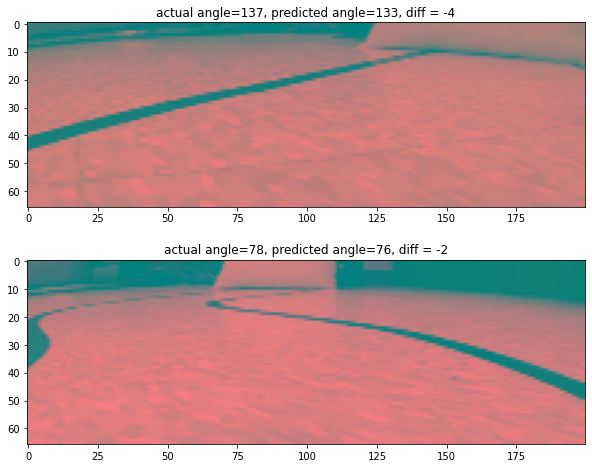

In [37]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")
    

As we can see the $R^2$ of the predicted was around 95% and Mean Squared Errors (MSE) are low, indicating the model is predicting a steering angle every simliar to our hand coded land follower, which was used as the model input. 

## References
1. Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba (2016) *End to End Learning for Self-Driving Cars*. Nvidia 
1. Rayan Slim, Amer Sharaf, Jad Slim (2017) *The Complete Self-Driving Car Course*. Udemy
1. Keras Documentation (2019) https://github.com/keras-team/keras/

